In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import csv
import re
from collections import defaultdict

In [68]:
# This will make the nested defaultdict picklable.  
def nested_dict(n, type):
    """
    Creates a nested defaultdict with n levels.

    Parameters:
    n (int): The number of nested levels for the defaultdict.
    type: The default data type for the defaultdict.

    Returns:
    defaultdict: A nested defaultdict with n levels.
    """
    def create_nested_dict(n, type):
        # A helper function that creates a nested defaultdict with n levels
        if n == 1:
            return defaultdict(type)
        else:
            return defaultdict(lambda: create_nested_dict(n-1, type))

    return create_nested_dict(n, type)

def drop_duplicates_except_metric(results,cols,rows):
    # Remove duplicates
    n_rows_before = len(results.index)
    cols_subset = [i for i in results.columns if i != 'test_task_mrr']
    results = results.drop_duplicates(subset=[cols,rows], keep='first')
    n_rows_after = len(results.index)
    print('n_rows_before',n_rows_before, 'n_rows_after', n_rows_after) if n_rows_before != n_rows_after else None
    return results

def string2list(df):
    for column in df:
        try:
            # For all the colum, apply eval() to convert the string to a list
            if column != 'kge':
                df[column] = [np.array(eval(i)) for i in df[column].values]
        except:
            # print("Couldnt convert ", column)
            continue

    # for each col that is a string or int or object, print the unique values 
    print('\nUnique values:')
    for col in df.columns:
        try: 
            if df[col].dtype == 'object' or df[col].dtype == 'int64' or df[col].dtype == 'string':
                print(col,df[col].unique())
        except:
            continue
    return df

def split_df(df):
    # create a df that is the same as the original but with the first value of the colums in the list metrics
    df_mean = df.copy()
    df_std = df.copy()
    for col in df_mean.columns:
        try:
            # df_mean[col] = [i[0] for i in df_mean[col].values]
            vals = []
            # print('col',col, 'df_mean[col].values',df_mean[col].values)
            for i in df_mean[col].values:
                if i is not np.nan:
                    vals.append(i[0])
                else:
                    vals.append(i)
            # substitute the values of the col with the new values
            df_mean[col] = vals
        except:
            continue
    # Do the same for the std
    for col in df_std.columns:
        try:
            # df_std[col] = [i[1] for i in df_std[col].values]
            vals = []
            for i in df_std[col].values:
                if i is not np.nan:
                    vals.append(i[1])
                else:
                    vals.append(i)
            # substitute the values of the col with the new values
            df_std[col] = vals
        except:
            continue
    return df_mean, df_std

In [69]:
tasks = ['countries_s1','countries_s2','countries_s3',
         'nations',
         'kinship_family','pharmkg_small','pharmkg_full',
         'FB15k237','wn18rr']
names_files = [""]# , ,'pharmkg',"long","nations",'kinship']
root = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\results\\experiments\\"
# root = 'C:\\Users\\rodri\\OneDrive - Università degli Studi di Siena\\Documents\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\results\\experiments\\'
for i,file in enumerate(names_files):
    path = root + "experiments"  + file + ".csv"
    dfi = pd.read_csv(path, sep=';', keep_default_na=False, skiprows=1, skip_blank_lines=True, comment='\n')
    dfi = dfi.drop_duplicates()
    if i == 0:
        df = dfi
    else:
        df = pd.concat([df, dfi], ignore_index=True)
df = df.drop_duplicates()
df = string2list(df)
# to avoid problems with the None from Rule miner
df['rule_miner'] = df['rule_miner'].apply(lambda x: 'No' if str(x) == 'None' else x)
print(df)


Unique values:
dataset_name ['countries_s1' 'countries_s2']
grounder ['backward_unknown2_1' 'backward_unknown2_2' 'backward_unknown2_3'
 'backward_unknown0_1' 'backward_unknown0_2' 'backward_unknown0_3'
 'backward_unknown1_1' 'backward_unknown1_2' 'backward_unknown1_3']
kge ['complex']
model_name ['dcr' 'sbr' 'r2n' 'no_reasoner']
kge_atom_embedding_size [100]
batch_size [-1]
val_batch_size [-1]
test_batch_size [256]
facts_file ['facts.txt']
train_file ['train.txt']
valid_file ['valid.txt']
test_file ['test.txt']
domain_file ['domain2constants.txt']
rules_file ['rules.txt']
corrupt_mode ['TAIL']
num_negatives [1]
valid_negatives [100]
format ['functional']
engine_num_negatives [0]
engine_num_adaptive_constants [0]
constant_embedding_size [200]
predicate_embedding_size [200]
epochs [100]
num_rules [1 0]
loss ['binary_crossentropy']
cdcr_num_formulas [3]
valid_frequency [5]
reasoner_depth [1]
reasoner_formula_hidden_embedding_size [100]
reasoner_atom_embedding_size [100]
filter_num_heads

In [70]:
# # Function to replace every cell in the 'Task' column containing 'reason' with the string until 'reason'
# def replace_until_reason(cell_value):
#     match = re.search(r'reason', cell_value)
#     if match:
#         return cell_value[:match.end()]
#     else:
#         return cell_value

# # Apply the function to each cell in the 'Task' column
# df['Task'] = df['Task'].apply(replace_until_reason)
# print(df['Task'].unique())

In [98]:
cols = 'grounder'
rows = 'model_name'
step = 'test'
metrics = [step+'_task_mrr', 'time_train','time_inference']
KGEs = ['complex'] #, 'distmult', 'transe']
baseline_model = 'no_reasoner'
baseline_metric = step + '_concept_mrr'
# select the rows from df where the column models has the values ['dcr','mno_reasoner'] 
models = ['sbr','dcr','r2n','no_reasoner'] # ,'gsbr','cdcr'
models_no_baseline = [i for i in models if i != baseline_model]
df = df.loc[df['model_name'].isin(models)]
rule_miners = ['No', 'amie'] 
grounders = ['backward_1', 'backward_2', 'backward_3','domainbody','full','relationentity',
            #  'backwardoriginal_1', 'backwardoriginal_2', 'backwardoriginal_3','backwardoriginal_prune_1', 'backwardoriginal_prune_2', 'backwardoriginal_prune_3',
             'backward_unknown1_1','backward_unknown1_2','backward_unknown1_3',
                'backward_unknown2_1','backward_unknown2_2','backward_unknown2_3',
                'backward_unknown3_1','backward_unknown3_2','backward_unknown3_3',
             ] 

models_name = {'sbr':'SBR', 'rnm':'RNM', 'dcr':'DCR', 'r2n':'R2N', 'no_reasoner':'Baseline'} #, 'gsbr':'GSBR', 'cdcr':'CDCR'
# models_name = {'r2n': 'Relational Reasoning Networks [3]' ,'sbr':'Semantic Based Regularization [2]', 'rnm':'Relational Neural Machines', 'dcr':'Deep Concept Reasoner [4]', 'r2n':'Relational Reasoning Networks[3]', 'no_reasoner':'Baseline'} #, 'gsbr':'GSBR', 'cdcr':'CDCR'
ground_name = {'relationentity':'Entity Rel.','backward_1':'Backward 1', 'backward_2':'Backward 2', 'backward_3':'Backward 3', 'full':'Full', 'domainbody':'Full', 
                'backward_prune_1':'Back. prune 1', 'backward_prune_2':'Back. prune 2', 'backward_prune_3':'Back. prune 3',
                'backwardoriginal_1':'Back. orig. 1', 'backwardoriginal_2':'Back. orig. 2', 'backwardoriginal_3':'Back. orig. 3',
                'backwardoriginal_prune_1':'Back. orig. prune 1', 'backwardoriginal_prune_2':'Back. orig. prune 2', 'backwardoriginal_prune_3':'Back. orig. prune 3',
                'backward_unknown1_1':'$BC^1_1$', 'backward_unknown1_2':'$BC^2_1$', 'backward_unknown1_3':'$BC^3_1$',
                'backward_unknown2_1':'$BC^1_2$', 'backward_unknown2_2':'$BC^2_2$', 'backward_unknown2_3':'$BC^3_2$',
                'backward_unknown3_1':'$BC^1_3$', 'backward_unknown3_2':'$BC^2_3$', 'backward_unknown3_3':'$BC^3_3$',
                }
metric_names = {step+'_task_mrr':'MRR', 'time':'Time (s)', 'time_train':'Train Time (s)', 'time_inference':'Inference Time (s)','test_task_hits@1@1':'Hits@1', 'test_task_hits@3@3':'Hits@3', 'test_task_hits@10@10':'Hits@10'}
dataset_names = {'countries_s2': 'Countries S2', 'countries_s3': 'Countries S3', 'countries_s1': 'Countries S1', 'nations': 'Nations', 
                 'kinship_family_small': 'Kinship Family Small', 'kinship_family': 'Kinship', 'pharmkg_supersmall': 'PharmKG Supersmall',
                  'kinship_family_reason_2': 'Kinship Family reason (2)', 'wn18rr': 'WN18RR','FB15k237': 'FB15k237',
                  'pharmkg_small': 'PharmKG small', 'pharmkg_full': 'PharmKG','pharmkg_small_reason_2': 'PharmKG small Reason',}
model_colors = {'sbr':'#1f77b4', 'rnm':'#ff7f0e', 'dcr':'#2ca02c', 'r2n':'#d62728', 'no_reasoner':'#9467bd'} #, 'gsbr':'#8c564b', 'cdcr':'#e377c2'

# Models in x axis

One table for the different models with KGE complex (also for the other KGEs)
Another table for the different KGEs
Another table for the time with the best model and the best KGE

In [15]:
# Table 1: rows:grounder, cols:Model, values: mrr
csv_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\results.csv"
# create the dict dfs with 4 levels of keys: task, KGE, metric, rule_miner
dfs = nested_dict(4, dict)
for task in tasks:
    for metric in metrics:
        for KGE in KGEs:
            for rule_miner in rule_miners:
                print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
                # verify that the rule miner is within the values of Rule_Miner, else continue
                
                miners_available = df.loc[ (df['Task'] == task) &(df['KGE'] == KGE)]['Rule_Miner'].unique()
                if (rule_miner not in miners_available):
                    print('Not available: rule_miner',rule_miner,'. Available: ',miners_available)
                    continue
                # filter the df
                results = df.loc[ (df['Task'] == task) &(df['KGE'] == KGE) &(df['Rule_Miner'] == rule_miner) ].copy() #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)].copy()
                # take only the columns grounder, model, test_task_mrr, test_concept_mrr
                results = results[[cols, rows, metric]]
                # Remove duplicates
                results = drop_duplicates_except_metric(results,cols,rows)
                # put the model_name as colums
                results = results.pivot(index=rows, columns=cols, values=metric)

                if metric == 'test_task_mrr':
                    # in the column no_reasoner, put the values of the column test_concept_mrr
                    substitute = df.loc[(df['Task'] == task) & (df['KGE'] == KGE) &(df['Rule_Miner'] == rule_miner) & (df['Model_name'] == baseline_model)][[cols,rows,baseline_metric]] #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)][[cols,rows,baseline_metric]]
                    # drop the duplicates , based on all the colums except for 'test_task_mrr'
                    substitute = drop_duplicates_except_metric(substitute,cols,rows)
                    substitute = substitute.pivot(index=rows, columns=cols, values=baseline_metric)
                    # substitute the values in the table
                    # print('\n\nsubstitute',substitute)
                    # print('\n\nresults',results)
                    if len(substitute) > 0:
                        results.loc[baseline_model] = substitute.loc[baseline_model] 
                    # print('\n\nresults',results)
                
                # obtain one df for the mean and one for the std
                results_mean, results_std = split_df(results)
                # append the results to dfs
                dfs[task][KGE][metric][rule_miner]['mean'] = results_mean
                dfs[task][KGE][metric][rule_miner]['std'] = results_std
                print('\n\nresults_mean',results_mean)
                
                # with open(csv_dir, 'a') as f:
                #     f.write('\n Task : ,' + task + 'KGE : ,' + KGE + ', Metric: ,' + metric)
                #     f.write('\n ') 
                # results.to_csv(csv_dir, mode='a', header=True)  
print(task, KGE, metric, rule_miner)
results_mean

KGE:  complex  Metric:  test_task_mrr  Task:  countries_s1  Rule miner:  No


KeyError: 'Task'

In [293]:
# # for every df of dfs, create a new df with the average over the models
# dfs_avg = nested_dict(4, dict)
# for task in tasks:
#     for metric in metrics:
#         for KGE in KGEs:
#             for rule_miner in rule_miners:
#                 for types in ['mean', 'std']:
#                     print(types, 'KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
#                     if rule_miner not in dfs[task][KGE][metric].keys():
#                         continue
#                     dfi = dfs[task][KGE][metric][rule_miner][types].copy()
#                     # select from dfi the models that are in models_no_baseline
#                     dfi = dfi.loc[models_no_baseline]
#                     dfi = dfi.mean(axis=0)
#                     dfi = pd.DataFrame(dfi)
#                     # set the name of the column as the metric
#                     dfi.columns = [metric]
#                     dfs_avg[task][KGE][metric][rule_miner][types] = dfi
#                     # print(dfi)
# dfi

## PLOTS

In [2]:
# # Table 1: rows:grounder, cols:Model, values: mrr
# metric_names = {step+'_task_mrr':'MRR', 'Time':'Time (s)'}
# root_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\figures\\"
# os.makedirs(root_dir) if not os.path.exists(root_dir) else None
# for task in tasks:
#     for metric in ['test_task_mrr']:
#         for KGE in KGEs:
#             for rule_miner in rule_miners:
#                 print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
#                 if rule_miner not in dfs[task][KGE][metric].keys():
#                     continue
#                 df_mean = dfs[task][KGE][metric][rule_miner]['mean']
#                 df_std = dfs[task][KGE][metric][rule_miner]['std']
#                 print(df_mean)
#                 # Remove no reasoner and include a line where it is written baseline
#                 plt.figure(figsize=(10,5))
#                 for i,grounder in enumerate(df_mean.loc[models_no_baseline].columns):
#                     plt.scatter(np.arange(len(df_mean.loc[models_no_baseline].index))+0.1*i, df_mean.loc[models_no_baseline][grounder], label=grounder, alpha=0.5)
#                     plt.errorbar(np.arange(len(df_mean.loc[models_no_baseline].index))+0.1*i, df_mean.loc[models_no_baseline][grounder], yerr=df_std.loc[models_no_baseline][grounder], fmt='o',capsize=5, alpha=0.5)
#                 if metric == step+'_task_mrr':
#                     plt.axhline(y=df_mean.loc[baseline_model].mean(), color='black', linestyle='--', alpha=.7)  # Change color and linestyle as desired
#                     plt.text(1.8, df_mean.loc[baseline_model].mean()-0.005, 'Baseline', color='black', fontsize=12, ha='center')
#                     # print(df_mean.loc[baseline_model].values[0])
#                 plt.legend()
#                 plt.xticks(np.arange(len(df_mean.loc[models_no_baseline].index))+0.2, df_mean.loc[models_no_baseline].index.tolist(), rotation=0)
#                 plt.ylabel(metric_names[metric])
#                 plt.xlabel('Model')
#                 min = np.array([i for i in df_mean.loc[models].values.ravel() if i != np.nan])
#                 max = np.array([i for i in df_mean.loc[models].values.ravel() if i != np.nan])
#                 if min.min()<10:
#                     print(min.min)
#                     plt.ylim(min.min()-0.1,max.max()+0.13)
#                 plt.title(f'Grounders across models. Task: {task}, KGE: {KGE}, Set: {step}, Rule miner: {rule_miner}')
#                 plt.show()
#                 # SAVE THE FIGURE
#                 # if the directory does not exist, create it
#                 # plt.savefig(root_dir+'Grounders_across_models__'+'Task_'+task+'_Metric_'+metric+'_KGE_'+KGE+'_rule_'+rule_miner+'.png', dpi=300, bbox_inches='tight')  

In [251]:
# # Now do the plot of the average over the models
# for task in tasks:
#     for metric in ['test_task_mrr']:
#         for KGE in KGEs:
#             for rule_miner in ['None', 'amie', 'ncrl']:
#                 print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
#                 if rule_miner not in dfs[task][KGE][metric].keys():
#                     continue
#                 df_mean = dfs_avg[task][KGE][metric][rule_miner]['mean']
#                 print(df_mean)
#                 df_std = dfs_avg[task][KGE][metric][rule_miner]['std']
#                 # Remove no reasoner and include a line where it is written baseline
#                 plt.figure(figsize=(10,5))
#                 plt.scatter(np.arange(len(df_mean.index)),df_mean.values.flatten(), alpha=0.5)
#                 plt.errorbar(np.arange(len(df_mean.index)),df_mean.values.flatten(), yerr=df_std.values.flatten(), fmt='o',capsize=5, alpha=0.5)
#                 if metric == step+'_task_mrr':
#                     baseline = dfs[task][KGE][metric][rule_miner]['mean'].loc[baseline_model].mean()
#                     plt.axhline(y=baseline, color='black', linestyle='--', alpha=.7)   
#                     plt.text(1.8, baseline-0.005, 'Baseline', color='black', fontsize=12, ha='center')
#                 # in the xlabel put the names of the grounders
#                 plt.xticks(np.arange(len(df_mean.index)), df_mean.index.tolist(), rotation=0)
#                 plt.ylabel(metric_names[metric])
#                 min = np.array([i for i in df_mean.values.flatten() if i != np.nan])
#                 max = np.array([i for i in df_mean.values.flatten() if i != np.nan])
#                 print(min.min() is np.nan)
#                 if min.min()<1:
#                     print(min.min)
#                     plt.ylim(min.min()-0.1,max.max()+0.1)
#                 plt.title(f'Grounders across models. Task: {task}, KGE: {KGE}, Set: {step}, Rule miner: {rule_miner}')
#                 plt.show()
#                 # SAVE THE FIGURE
#                 # if the directory does not exist, create it
#                 # plt.savefig(root_dir+'Grounders_across_models__'+'Task_'+task+'_Metric_'+metric+'_KGE_'+KGE+'_rule_'+rule_miner+'.png', dpi=300, bbox_inches='tight')  

# Grounders in x axis

In [79]:
rows = 'grounder'
cols = 'model_name'
# Table 1: rows:grounder, cols:Model, values: mrr
csv_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\results.csv"
# create the dict dfs with 4 levels of keys: task, KGE, metric, rule_miner
dfs = nested_dict(4, dict)
for task in tasks:
    for metric in metrics:
        for KGE in KGEs:
            for rule_miner in rule_miners:                # verify that the rule miner is within the values of Rule_Miner, else continue
                miners_available = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE)]['rule_miner'].apply(lambda x: str(x)).unique()
                if (rule_miner not in miners_available):
                    continue
                print('\nTask: ', task, 'KGE: ', KGE, ' Metric: ', metric,  ' Rule miner: ', rule_miner)
                # filter the df
                results = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & df['grounder'].isin(grounders)].copy() #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)].copy()
                # take only the columns grounder, model, test_task_mrr, test_concept_mrr
                results = results[[cols, rows, metric]]
                # Remove duplicates
                results = drop_duplicates_except_metric(results,cols,rows)
                # put the model_name as colums
                results = results.pivot(index=rows, columns=cols, values=metric)
                print('results',results)
                # print('metric',metric)  
                if metric == 'test_task_mrr':
                    # in the column no_reasoner, put the values of the column test_concept_mrr
                    substitute = df.loc[(df['dataset_name'] == task) & (df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & (df['model_name'] == baseline_model)][[cols,rows,baseline_metric]] #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)][[cols,rows,baseline_metric]]
                    # drop the duplicates , based on all the colums except for 'test_task_mrr'
                    substitute = drop_duplicates_except_metric(substitute,cols,rows)
                    substitute = substitute.pivot(index=rows, columns=cols, values=baseline_metric)
                    # substitute the values in the table
                    if len(substitute) > 0:
                        results[baseline_model] = substitute[baseline_model] 
                    # print('\nsubstitute',results)
                
                # obtain one df for the mean and one for the std
                results_mean, results_std = split_df(results)
                # append the results to dfs
                dfs[task][KGE][metric][rule_miner]['mean'] = results_mean
                dfs[task][KGE][metric][rule_miner]['std'] = results_std
                # print('results_mean',results_mean)
                
                # with open(csv_dir, 'a') as f:
                #     f.write('\n Task : ,' + task + 'KGE : ,' + KGE + ', Metric: ,' + metric)
                #     f.write('\n ') 
                # results.to_csv(csv_dir, mode='a', header=True)  
print(task, KGE, metric, rule_miner)
results_mean


Task:  countries_s1 KGE:  complex  Metric:  test_task_mrr  Rule miner:  No
results model_name                      dcr    no_reasoner         r2n         sbr
grounder                                                                  
backward_unknown1_1  [0.998, 0.004]  [0.94, 0.016]  [1.0, 0.0]  [1.0, 0.0]
backward_unknown1_2  [0.998, 0.004]  [0.94, 0.016]  [1.0, 0.0]  [1.0, 0.0]
backward_unknown1_3  [0.998, 0.004]  [0.94, 0.016]  [1.0, 0.0]  [1.0, 0.0]
backward_unknown2_1      [1.0, 0.0]  [0.94, 0.016]  [1.0, 0.0]  [1.0, 0.0]
backward_unknown2_2  [0.998, 0.004]  [0.94, 0.016]  [1.0, 0.0]  [1.0, 0.0]
backward_unknown2_3  [0.998, 0.004]  [0.94, 0.016]  [1.0, 0.0]  [1.0, 0.0]

Task:  countries_s1 KGE:  complex  Metric:  time_train  Rule miner:  No
results model_name                       dcr      no_reasoner              r2n  \
grounder                                                                 
backward_unknown1_1   [23.32, 0.527]  [17.712, 0.343]  [20.128, 0.035]   
backward_unkn

model_name,dcr,sbr
grounder,,
backward_unknown2_1,3.974,3.926


KGE:  complex  Metric:  test_task_mrr  Task:  countries_s1  Rule miner:  No
Best result:  1.0 Baseline:  0.94


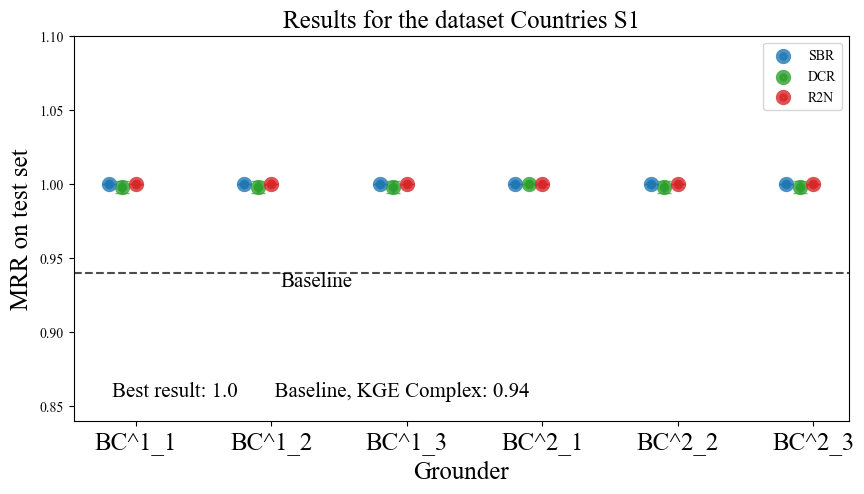

KGE:  complex  Metric:  test_task_mrr  Task:  countries_s1  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  countries_s2  Rule miner:  No


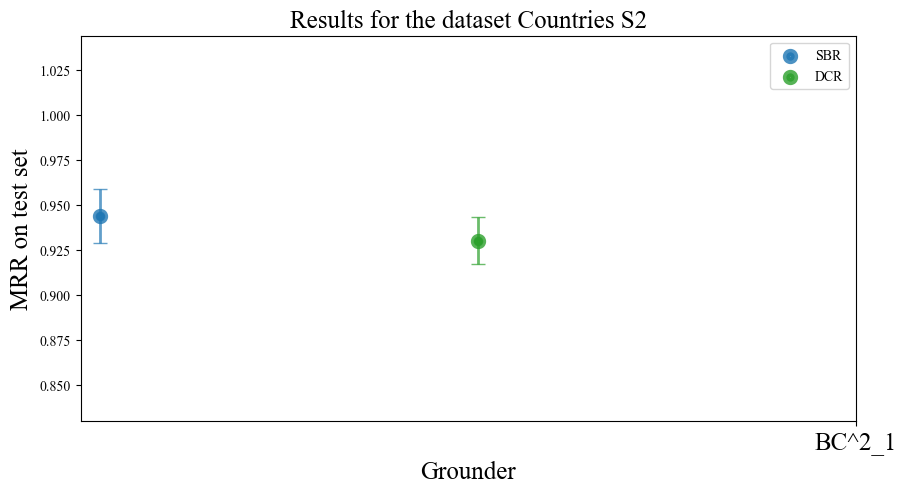

KGE:  complex  Metric:  test_task_mrr  Task:  countries_s2  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  countries_s3  Rule miner:  No
KGE:  complex  Metric:  test_task_mrr  Task:  countries_s3  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  nations  Rule miner:  No
KGE:  complex  Metric:  test_task_mrr  Task:  nations  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  kinship_family  Rule miner:  No
KGE:  complex  Metric:  test_task_mrr  Task:  kinship_family  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  pharmkg_small  Rule miner:  No
KGE:  complex  Metric:  test_task_mrr  Task:  pharmkg_small  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  pharmkg_full  Rule miner:  No
KGE:  complex  Metric:  test_task_mrr  Task:  pharmkg_full  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  FB15k237  Rule miner:  No
KGE:  complex  Metric:  test_task_mrr  Task:  FB15k237  Rule miner:  amie
KGE:  comp

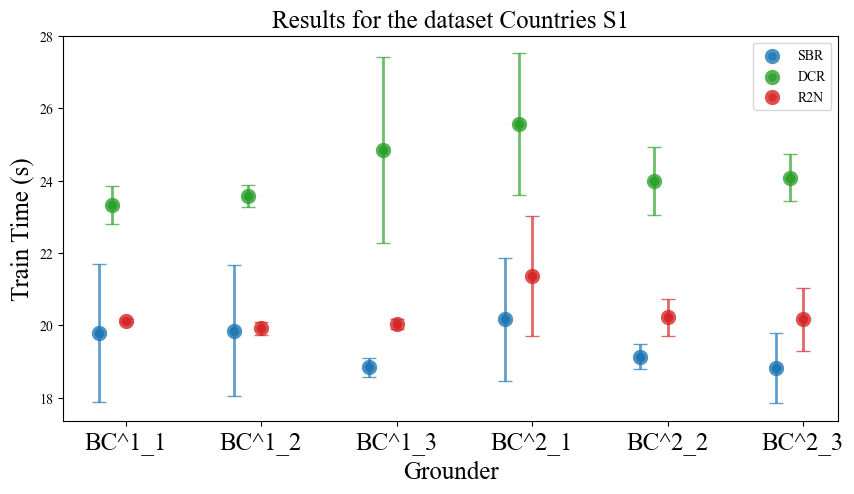

KGE:  complex  Metric:  time_train  Task:  countries_s1  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  countries_s2  Rule miner:  No


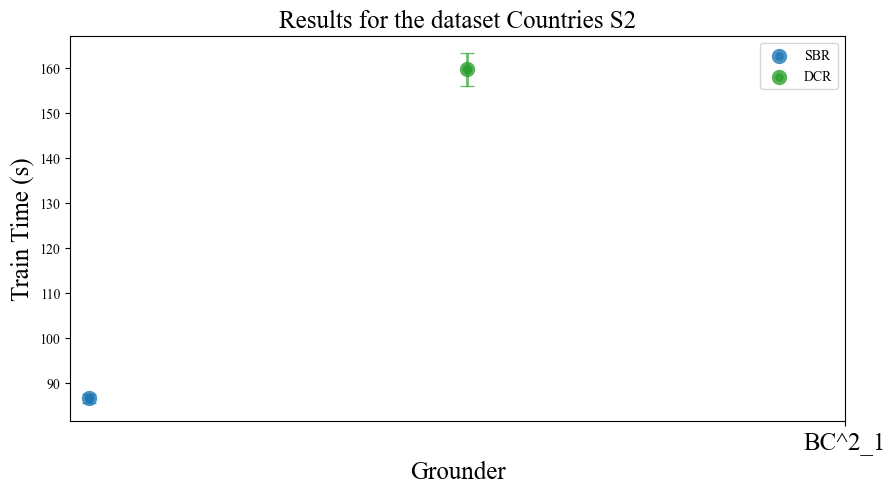

KGE:  complex  Metric:  time_train  Task:  countries_s2  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  countries_s3  Rule miner:  No
KGE:  complex  Metric:  time_train  Task:  countries_s3  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  nations  Rule miner:  No
KGE:  complex  Metric:  time_train  Task:  nations  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  kinship_family  Rule miner:  No
KGE:  complex  Metric:  time_train  Task:  kinship_family  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  pharmkg_small  Rule miner:  No
KGE:  complex  Metric:  time_train  Task:  pharmkg_small  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  pharmkg_full  Rule miner:  No
KGE:  complex  Metric:  time_train  Task:  pharmkg_full  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  FB15k237  Rule miner:  No
KGE:  complex  Metric:  time_train  Task:  FB15k237  Rule miner:  amie
KGE:  complex  Metric:  time_train  Task:  wn18rr

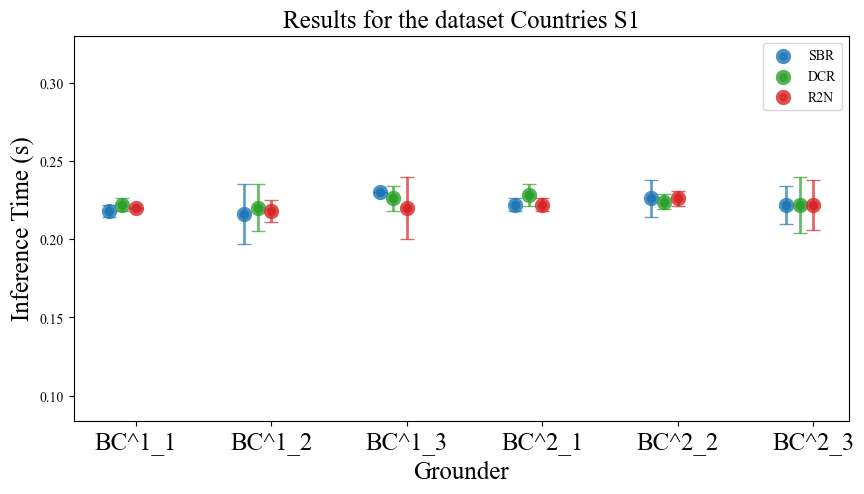

KGE:  complex  Metric:  time_inference  Task:  countries_s1  Rule miner:  amie
KGE:  complex  Metric:  time_inference  Task:  countries_s2  Rule miner:  No


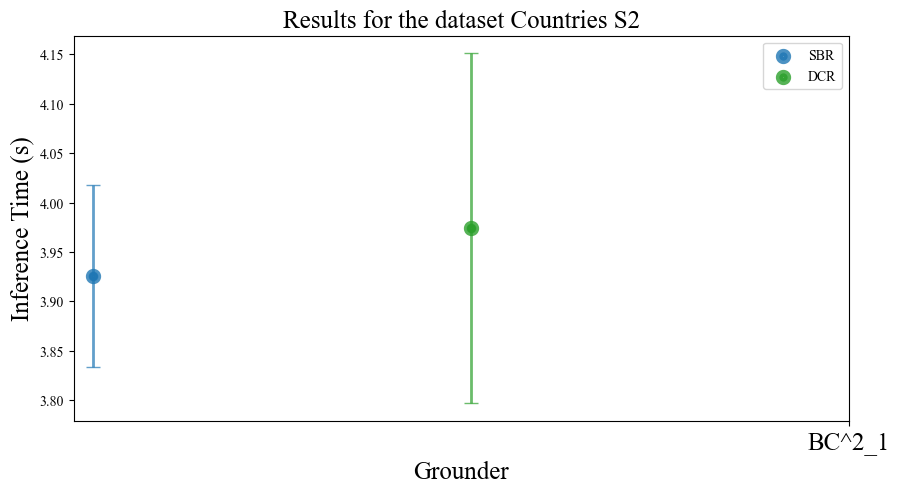

KGE:  complex  Metric:  time_inference  Task:  countries_s2  Rule miner:  amie
KGE:  complex  Metric:  time_inference  Task:  countries_s3  Rule miner:  No
KGE:  complex  Metric:  time_inference  Task:  countries_s3  Rule miner:  amie
KGE:  complex  Metric:  time_inference  Task:  nations  Rule miner:  No
KGE:  complex  Metric:  time_inference  Task:  nations  Rule miner:  amie
KGE:  complex  Metric:  time_inference  Task:  kinship_family  Rule miner:  No
KGE:  complex  Metric:  time_inference  Task:  kinship_family  Rule miner:  amie
KGE:  complex  Metric:  time_inference  Task:  pharmkg_small  Rule miner:  No
KGE:  complex  Metric:  time_inference  Task:  pharmkg_small  Rule miner:  amie
KGE:  complex  Metric:  time_inference  Task:  pharmkg_full  Rule miner:  No
KGE:  complex  Metric:  time_inference  Task:  pharmkg_full  Rule miner:  amie
KGE:  complex  Metric:  time_inference  Task:  FB15k237  Rule miner:  No
KGE:  complex  Metric:  time_inference  Task:  FB15k237  Rule miner:  am

In [80]:
# select the times new roman font
plt.rcParams['font.family'] = 'Times New Roman'
root_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\figures\\"
for metric in metrics:
    for task in tasks:
        for KGE in KGEs:
            for rule_miner in rule_miners:
                print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
                if rule_miner not in dfs[task][KGE][metric].keys():
                    continue
                subset_models = [i for i in models_no_baseline if i in list(dfs[task][KGE][metric][rule_miner]['mean'].keys())]
                df_mean = dfs[task][KGE][metric][rule_miner]['mean'][subset_models]                    
                df_std = dfs[task][KGE][metric][rule_miner]['std'][subset_models]
                try:
                    df_mean_baseline = dfs[task][KGE][metric][rule_miner]['mean'][baseline_model].mean()
                    baseline_found = True
                except:
                    baseline_found = False
                # df_std_baseline = dfs[task][KGE][metric][rule_miner]['std'][baseline_model]
                # Remove no reasoner and include a line where it is written baseline
                plt.figure(figsize=(10,5))
                for i,model in enumerate(df_mean.columns):
                    color = model_colors[model]
                    try:
                        plt.scatter(np.arange(len(df_mean.index))+0.1*i, df_mean[model], label=models_name[model], alpha=.8,linewidth=5,color=color) 
                        plt.errorbar(np.arange(len(df_mean.index))+0.1*i, df_mean[model], yerr=df_std[model], fmt='o',capsize=5, alpha=.7,linewidth=2,color=color)
                    except:
                        continue
                plt.legend()
                labels = [ground_name[i] for i in df_mean.index]
                plt.xticks(np.arange(len(df_mean.index))+0.2, labels, rotation=0, fontsize=18)
                if 'time' in metric:
                    plt.ylabel(metric_names[metric], fontsize=18)
                else:
                    plt.ylabel(metric_names[metric]+' on '+step+' set', fontsize=18)
                plt.xlabel('Grounder', fontsize=18)
                min = np.array([i for i in dfs[task][KGE][metric][rule_miner]['mean'].values.ravel() if not np.isnan(i)])  
                max = np.array([i for i in dfs[task][KGE][metric][rule_miner]['mean'].values.ravel() if not np.isnan(i)]) 

                if min.min()<1: #max.max()<=.9:
                    plt.ylim(min.min()-0.1,max.max()+0.1)
                # elif max.max()>=.9:
                #     plt.ylim(min.min()-0.1,1.01)
                if metric == step+'_task_mrr' and baseline_found:
                    print('Best result: ',max.max(), 'Baseline: ', np.round(df_mean_baseline,3))
                    plt.axhline(y=df_mean_baseline, color='black', linestyle='--', alpha=.7)  # Change color and linestyle as desired
                    plt.text(1.8, df_mean_baseline-0.009, 'Baseline', color='black', fontsize=15, ha='right',clip_on=True)
                    plt.text(0.05, 0.05, 'Best result: '+str(np.round(max.max(),3))+'       Baseline, KGE Complex: '+str(np.round(df_mean_baseline,3)), transform=plt.gca().transAxes,
                            fontsize=15, verticalalignment='bottom', horizontalalignment='left')
                plt.title(f'Results for the dataset {dataset_names[task]}', fontsize=18)
                # plt.title(f'Dataset: {dataset_names[task]}, KGE: {KGE}, Set: {step}, Rule miner: {rule_miner}')
                plt.show()
                # SAVE THE FIGURE
                # if the directory does not exist, create it
                # os.makedirs(root_dir) if not os.path.exists(root_dir) else None
                # plt.savefig(root_dir+'Grounders_across_models__'+'Task_'+task+'_Metric_'+metric+'_KGE_'+KGE+'_rule_'+rule_miner+'.png', dpi=300, bbox_inches='tight')  

In [21]:
# tables for overleaf
for task in dfs.keys():
    for KGE in dfs[task].keys():
        for metric in dfs[task][KGE].keys():
            for rule_miner in dfs[task][KGE][metric].keys():
                try:
                    print('Task: ', task, 'KGE: ', KGE, ' Metric: ', metric, ' Rule miner: ', rule_miner)
                    print(dfs[task][KGE][metric][rule_miner]['mean'])
                    print('latex code:')
                    print(dfs[task][KGE][metric][rule_miner]['mean'].to_latex())
                    # show the table in pd instead of series
                    print(dfs[task][KGE][metric][rule_miner][['mean']])
                except:
                    continue

Task:  countries_s1 KGE:  complex  Metric:  test_task_mrr  Rule miner:  No
model_name    dcr  no_reasoner    r2n    sbr
grounder                                    
backward_1  1.000        0.951  1.000  0.995
backward_2  1.000        0.951  1.000  0.996
backward_3  1.000        0.949  1.000  1.000
domainbody  0.962        0.951  0.952  0.973
latex code:
Task:  countries_s1 KGE:  complex  Metric:  time_train  Rule miner:  No
model_name     dcr  no_reasoner     r2n     sbr
grounder                                       
backward_1  26.192       19.908  22.410  20.560
backward_2  26.930       19.988  22.876  21.582
backward_3  27.360       20.142  22.598  21.790
domainbody  32.874       20.018  29.392  23.902
latex code:
Task:  countries_s1 KGE:  complex  Metric:  time_inference  Rule miner:  No
model_name    dcr  no_reasoner    r2n    sbr
grounder                                    
backward_1  0.212        0.190  0.212  0.212
backward_2  0.230        0.212  0.224  0.232
backward_3  0.2

In [22]:
d = dfs['countries_s1']['complex']['test_task_mrr']['No']['mean'].copy()
d = d[models]
# Substitute by the proper names 
d.columns = [models_name[i] for i in d.columns]
d.index = [ground_name[i] for i in d.index]
# drop the column of the baseline in backward 1
baseline = d['Baseline'].loc['Backward 1']
d


,SBR,DCR,R2N,Baseline
Backward 1,0.995,1.000,1.000,0.951
Backward 2,0.996,1.000,1.000,0.951
Backward 3,1.000,1.000,1.000,0.949
Full,0.973,0.962,0.952,0.951


# Tables for overleaf

In [99]:
rows = 'grounder'
cols = ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10','time_train','time_inference']
models_results = []
best_results = nested_dict(3, dict)
# for task in ['kinship_family','pharmkg_small','pharmkg_full','wn18rr', 'FB15k237' ]:
# for task in ['countries_s1','countries_s2','countries_s3','kinship_family','pharmkg_small']:#tasks:
for task in ['countries_s1']:
    df_table = None
    # for model in models_no_baseline:
    for KGE in KGEs:
        for rule_miner in rule_miners:                # verify that the rule miner is within the values of Rule_Miner, else continue
            miners_available = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE)]['rule_miner'].apply(lambda x: str(x)).unique()
            if (rule_miner not in miners_available):
                continue
            print('\nTask',task,'KGE: ', KGE, ' Rule miner: ', rule_miner)
            # filter the df
            results = df.loc[(df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & df['grounder'].isin(grounders)].copy() #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)].copy()
            # print('\nresults',results) 
            # take only the columns grounder, model, test_task_mrr, test_concept_mrr
            results = results[['dataset_name','model_name',rows]+cols]
            results = results.sort_values(by=['dataset_name', 'model_name', 'grounder'])
            # get the results of the baseline
            baseline = df.loc[(df['model_name'] == 'no_reasoner') & (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) &(df['grounder'] == 'backward_1') ][['grounder']+cols]
            # print(baseline)
            # add the baseline to the list
            # if the baseline is empty, append '-'
            if len(baseline) == 0:
                list_to_append  = [task,'ComplEX','-'] + ['-']*(len(cols))
            else:
                list_to_append  =  list(baseline.values[0])
                list_to_append[list_to_append.index('backward_1')] = '-'
                list_to_append = [task,'ComplEX'] + list_to_append
            # Remove all the rows that contain a 'no_reasoner' in the model_name
            results = results[results['model_name'] != 'no_reasoner']
            results = results.reset_index(drop=True)
            # print(resuls.columns)
            results.loc[len(results)] = list_to_append
            # print('\nresults',results) 
            # for the colums ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10'], get the best result, which is in the first element of the list of each cell
            for col in ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10']:
                # best_results[task][col] = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x).max()
                results_ = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x)
                best_results[task][col]  =  results_[results_.apply(lambda x: type(x) is not str)].max()
                # print('\nbest_results',col,best_results[model][task][col])
            results = results.reset_index(drop=True)
            if df_table is None:
                df_table = results
            else:
                df_table = pd.concat([df_table, results], ignore_index=True)
    # add the model to the list
    models_results.append(df_table)



Task countries_s1 KGE:  complex  Rule miner:  No


In [100]:
def bold_best_result_col(x, best_results, task, col):
    if type(x) is np.ndarray:
        mean_original,var_original = x
        # if 'inference' in col:
        #     mean,var = round(mean_original,1),round(var_original,1)
        #     if task in ['pharmkg_full','wn18rr', 'FB15k237' ]:
        #         return str(mean)
        #     else:
        #         return str(mean)+'±'+str(var)
        
        if 'time' in col:
            mean = round(mean_original,1)
            return str(mean) 

        else:
            mean,var = round(100*mean_original,1),round(100*var_original,1)
        # print('mean_original',mean_original, task,col,best_results[model][task][col])
            if mean_original == best_results[task][col]:
                if task in ['pharmkg_full','wn18rr', 'FB15k237' ]:
                    return '\\textbf{'+str(mean)+'}'
                else: 
                    return '\\textbf{'+str(mean)+'}±'+str(var)
            else:
                if task in ['pharmkg_full','wn18rr', 'FB15k237' ]:
                    return str(mean)
                else:
                    return str(mean)+'±'+str(var)
    else:
        return x
    

for i,df_table in enumerate(models_results):
    # convert the content of every cell in cols from '[n1,n2]' to str(n1)+'+'+str(n2) if the content is not a string
    for col in cols:
        # df_table[col] = df_table[col].apply(lambda x: str(x[0])+'±'+str(x[1]) if type(x) is np.ndarray else x)
        df_table[col] = df_table.apply(lambda x: bold_best_result_col(x[col], best_results, x['dataset_name'], col), axis=1)
    

    # substitute the names of the colums by the proper names. For column, if its name is in metric_names, substitute it by the value of the dictionary
    list_cols = ['Dataset','Model', 'Grounder'] + [metric_names[i] if i in metric_names.keys() else i for i in cols]
    df_table.columns = list_cols

    # in df_table, subtitute in the column Dataset the names of the datasets by the proper names, and do the same for the grounders
    df_table['Dataset'] = df_table['Dataset'].apply(lambda x: dataset_names[x])
    df_table['Model'] = df_table['Model'].apply(lambda x: models_name[x] if x in models_name.keys() else x)
    df_table['Grounder'] = df_table['Grounder'].apply(lambda x: ground_name[x] if x in ground_name.keys() else x)
    df_table = df_table.reset_index(drop=True)

In [101]:
# df_table_final = pd.concat([models_results[3],models_results[4],models_results[5],models_results[6]], ignore_index=True)
# df_table_final = pd.concat([models_results[0],models_results[1],models_results[2]], ignore_index=True)
df_table_final = pd.concat(models_results, ignore_index=True)
# show the full df in the print
pd.set_option('display.max_rows', None) 
# models_results[2]
df_table_final

,Dataset,Model,Grounder,MRR,Hits@1,Hits@3,Hits@10,Train Time (s),Inference Time (s)
0,Countries S1,DCR,$BC^1_1$,99.8±0.4,99.6±0.8,\textbf{100.0}±0.0,\textbf{100.0}±0.0,23.3,0.2
1,Countries S1,DCR,$BC^2_1$,99.8±0.4,99.6±0.8,\textbf{100.0}±0.0,\textbf{100.0}±0.0,23.6,0.2
2,Countries S1,DCR,$BC^3_1$,99.8±0.4,99.6±0.8,\textbf{100.0}±0.0,\textbf{100.0}±0.0,24.9,0.2
3,Countries S1,DCR,$BC^1_2$,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,25.6,0.2
4,Countries S1,DCR,$BC^2_2$,99.8±0.4,99.6±0.8,\textbf{100.0}±0.0,\textbf{100.0}±0.0,24.0,0.2
5,Countries S1,DCR,$BC^3_2$,99.8±0.4,99.6±0.8,\textbf{100.0}±0.0,\textbf{100.0}±0.0,24.1,0.2
6,Countries S1,R2N,$BC^1_1$,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,20.1,0.2
7,Countries S1,R2N,$BC^2_1$,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,19.9,0.2
8,Countries S1,R2N,$BC^3_1$,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,20.0,0.2
9,Countries S1,R2N,$BC^1_2$,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,21.4,0.2


In [102]:
print(df_table_final.to_latex(index=False))

\begin{tabular}{lllllllll}
\toprule
Dataset & Model & Grounder & MRR & Hits@1 & Hits@3 & Hits@10 & Train Time (s) & Inference Time (s) \\
\midrule
Countries S1 & DCR & $BC^1_1$ & 99.8±0.4 & 99.6±0.8 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 23.3 & 0.2 \\
Countries S1 & DCR & $BC^2_1$ & 99.8±0.4 & 99.6±0.8 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 23.6 & 0.2 \\
Countries S1 & DCR & $BC^3_1$ & 99.8±0.4 & 99.6±0.8 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 24.9 & 0.2 \\
Countries S1 & DCR & $BC^1_2$ & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 25.6 & 0.2 \\
Countries S1 & DCR & $BC^2_2$ & 99.8±0.4 & 99.6±0.8 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 24.0 & 0.2 \\
Countries S1 & DCR & $BC^3_2$ & 99.8±0.4 & 99.6±0.8 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 24.1 & 0.2 \\
Countries S1 & R2N & $BC^1_1$ & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 20.1 & 0.2 \\
Countries S1 & R2N & $BC^2_1$ & \textbf{100

# Create the table for the overleaf by models

In [7]:
rows = 'grounder'
cols = ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10','time_train','time_inference']
models_results = []
best_results = nested_dict(3, dict)
for model in models_no_baseline:
    df_table = None
    # for task in ['countries_s1','countries_s2','countries_s3','nations','kinship_family','pharmkg_small']:#tasks:
    for task in ['pharmkg_full','wn18rr', 'FB15k237' ]:
        for KGE in KGEs:
            for rule_miner in rule_miners:                # verify that the rule miner is within the values of Rule_Miner, else continue
                miners_available = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE)]['rule_miner'].apply(lambda x: str(x)).unique()
                if (rule_miner not in miners_available):
                    continue
                print('\nModel',model,' Task: ', task, 'KGE: ', KGE, ' Metric: ', metric,  ' Rule miner: ', rule_miner)
                # filter the df
                results = df.loc[(df['model_name'] == model) & (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & df['grounder'].isin(grounders)].copy() #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)].copy()
                # take only the columns grounder, model, test_task_mrr, test_concept_mrr
                results = results[['dataset_name',rows]+cols]
                # get the results of the baseline
                baseline = df.loc[(df['model_name'] == 'no_reasoner') & (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) &(df['grounder'] == 'backward_1') ][['grounder']+cols]
                # print(baseline)
                # add the baseline to the list
                # if the baseline is empty, append '-'
                if len(baseline) == 0:
                    list_to_append  = [task,'Baseline'] + ['-']*(len(cols))
                else:
                    list_to_append  = [task] + list(baseline.values[0])
                    list_to_append[list_to_append.index('backward_1')] = 'Baseline'
                results = results.reset_index(drop=True)
                results.loc[len(results)] = list_to_append
                print('\nresults',results) 
                # for the colums ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10'], get the best result, which is in the first element of the list of each cell
                for col in ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10']:
                    # best_results[task][col] = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x).max()
                    results_ = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x)
                    best_results[model][task][col]  =  results_[results_.apply(lambda x: type(x) is not str)].max()
                    print('\nbest_results',col,best_results[model][task][col])
                results = results.reset_index(drop=True)
                if df_table is None:
                    df_table = results
                else:
                    df_table = pd.concat([df_table, results], ignore_index=True)
    # add the model to the list
    models_results.append(df_table)


NameError: name 'metric' is not defined

In [40]:
def bold_best_result_col(x, best_results,model, task, col):
    if type(x) is np.ndarray:
        mean_original,var_original = x
        if 'time' in col:
            mean,var = round(mean_original,1),round(var_original,1)
        else:
            mean,var = round(100*mean_original,1),round(100*var_original,1)
        # print('mean_original',mean_original, task,col,best_results[model][task][col])
        if mean_original == best_results[model][task][col]:
            return '\\textbf{'+str(mean)+'}±'+str(var)
        else:
            return str(mean)+'±'+str(var)
    else:
        return x
    

for i,df_table in enumerate(models_results):
    # convert the content of every cell in cols from '[n1,n2]' to str(n1)+'+'+str(n2) if the content is not a string
    for col in cols:
        # df_table[col] = df_table[col].apply(lambda x: str(x[0])+'±'+str(x[1]) if type(x) is np.ndarray else x)
        df_table[col] = df_table.apply(lambda x: bold_best_result_col(x[col], best_results,models_no_baseline[i], x['dataset_name'], col), axis=1)
    

    # substitute the names of the colums by the proper names. For column, if its name is in metric_names, substitute it by the value of the dictionary
    list_cols = ['Dataset', 'Grounder'] + [metric_names[i] if i in metric_names.keys() else i for i in cols]
    df_table.columns = list_cols

    # in df_table, subtitute in the column Dataset the names of the datasets by the proper names, and do the same for the grounders
    df_table['Dataset'] = df_table['Dataset'].apply(lambda x: dataset_names[x])
    df_table['Grounder'] = df_table['Grounder'].apply(lambda x: ground_name[x] if x in ground_name.keys() else x)
    df_table = df_table.reset_index(drop=True)

In [41]:
# show the full df in the print
pd.set_option('display.max_rows', None) 
models_results[2]

,Dataset,Grounder,MRR,Hits@1,Hits@3,Hits@10,Train Time (s),Inference Time (s)
0,PharmKG,Backward 1,\textbf{54.0}±0.0,\textbf{51.7}±0.0,\textbf{53.7}±0.0,\textbf{58.4}±0.0,1481.7±0.0,17379.3±0.0
1,PharmKG,Baseline,53.2±0.0,51.6±0.0,53.1±0.0,56.0±0.0,216.9±0.0,1996.8±0.0
2,WN18RR,Backward 1,51.8±0.0,51.2±0.0,52.1±0.0,52.5±0.0,204.7±0.0,3666.0±0.0
3,WN18RR,Backward 2,\textbf{58.8}±0.0,\textbf{55.5}±0.0,\textbf{60.9}±0.0,\textbf{65.5}±0.0,2354.4±0.0,15575.7±0.0
4,WN18RR,Baseline,50.8±0.0,50.5±0.0,50.9±0.0,51.3±0.0,46.9±0.0,1084.3±0.0


In [45]:
number = 2
print(models_no_baseline[number])
print(models_results[number].to_latex(index=False))

r2n
\begin{tabular}{llllllll}
\toprule
Dataset & Grounder & MRR & Hits@1 & Hits@3 & Hits@10 & Train Time (s) & Inference Time (s) \\
\midrule
PharmKG & Backward 1 & \textbf{54.0}±0.0 & \textbf{51.7}±0.0 & \textbf{53.7}±0.0 & \textbf{58.4}±0.0 & 1481.7±0.0 & 17379.3±0.0 \\
PharmKG & Baseline & 53.2±0.0 & 51.6±0.0 & 53.1±0.0 & 56.0±0.0 & 216.9±0.0 & 1996.8±0.0 \\
WN18RR & Backward 1 & 51.8±0.0 & 51.2±0.0 & 52.1±0.0 & 52.5±0.0 & 204.7±0.0 & 3666.0±0.0 \\
WN18RR & Backward 2 & \textbf{58.8}±0.0 & \textbf{55.5}±0.0 & \textbf{60.9}±0.0 & \textbf{65.5}±0.0 & 2354.4±0.0 & 15575.7±0.0 \\
WN18RR & Baseline & 50.8±0.0 & 50.5±0.0 & 50.9±0.0 & 51.3±0.0 & 46.9±0.0 & 1084.3±0.0 \\
\bottomrule
\end{tabular}

